### 1. Описание набора данных

Набор данных ```German Credit``` содержит сведения о людях, которые берут кредит в банке, где каждый человек классифицируется как хороший или плохой заемщик (кредитный риск).

### 2. Импорт библиотек

In [24]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import urllib.request
import warnings

from catboost import CatBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
  accuracy_score,
  classification_report,
  confusion_matrix,
  f1_score,
  mean_squared_error,
  recall_score,
  roc_auc_score
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler

In [6]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 3. Определение функций

In [7]:
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x, y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
  rcorr = r - ((r - 1) ** 2) / (n - 1)
  kcorr = k - ((k - 1) ** 2) / (n - 1)
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [8]:
def cramers_col(X, columns, column_name):
  col = pd.Series(np.empty(X[columns].columns.shape), index=X[columns].columns, name=column_name)
  for row in X[columns]:
    cram = cramers_v(X[columns][column_name], X[columns][row])
    col[row] = round(cram, 2)
  return col

### 4. Создание каталога и скачивание данных

In [9]:
if not os.path.exists('data'):
  os.makedirs('data')

if not os.path.exists('data/german_credit.csv'):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab3/data/german_credit.csv', 'data/german_credit.csv')

### 5. Загрузка набора данных из файла

In [10]:
df = pd.read_csv('data/german_credit.csv')
df.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


### 6. Предварительный анализ и обработка данных данных

#### 6.1. Вывод информации и структуре данных

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

#### 6.2. Разделение набора данных на набор с признаками и целевой переменной

In [12]:
X, y = df.drop(columns = ['Creditability']), df['Creditability']

#### 6.3. Вывод гистограмм распределения признаков

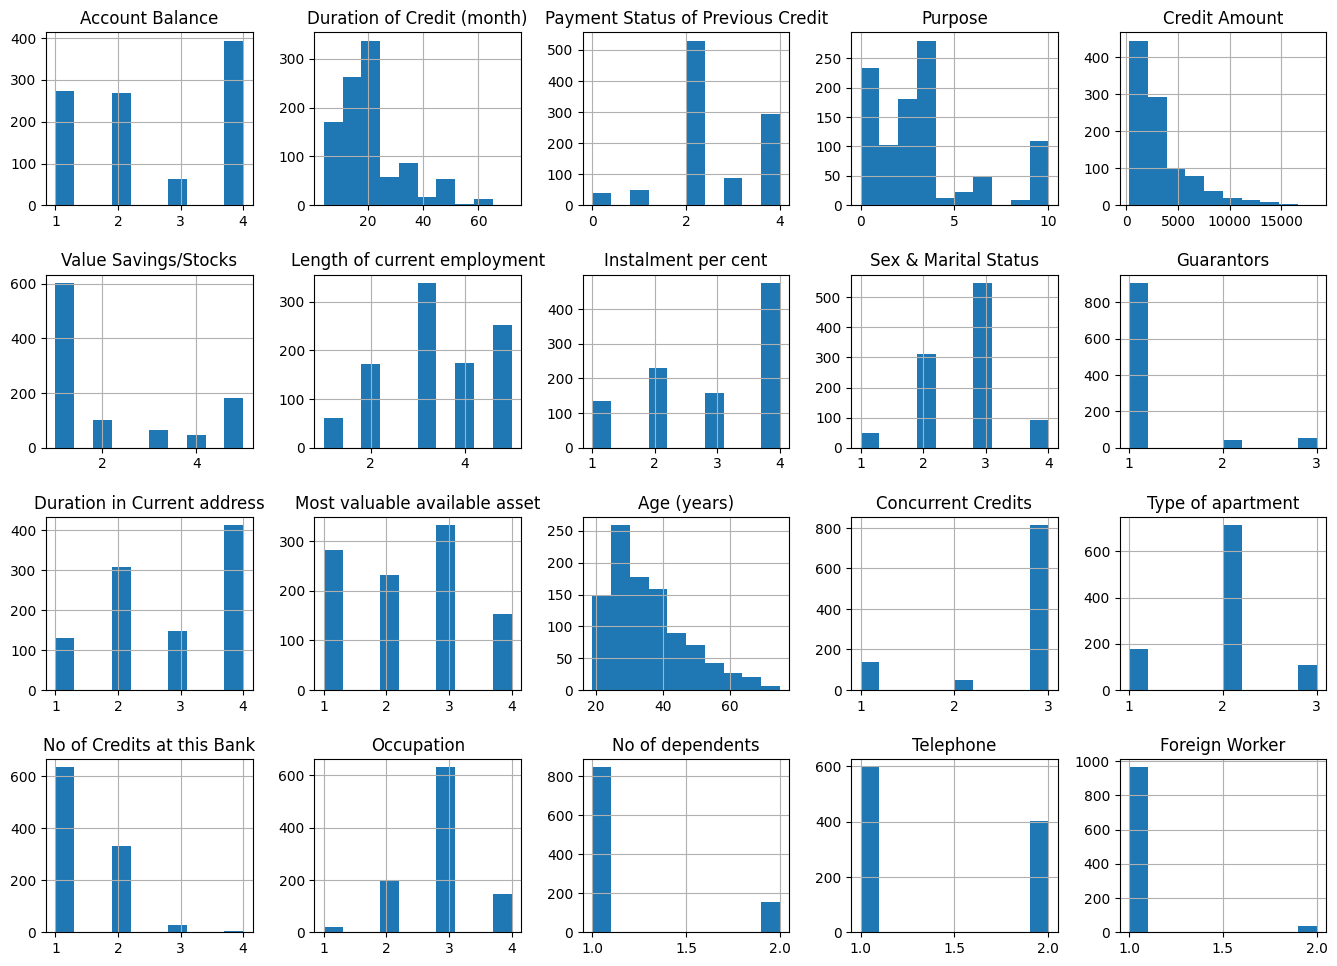

In [13]:
num_rows = 4
num_columns = 5

fig, axes = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(16, 10))

for i, column in enumerate(X.columns):
  row = i // num_columns
  col = i % num_columns

  X[column].hist(ax=axes[row, col], bins=10)
  axes[row, col].set_title(column)

plt.subplots_adjust(left=0, right=0.8, bottom=0, top=0.9, wspace=0.3, hspace=0.4)
plt.show()

#### 6.4. Выделение категориальных и числовых признаков

In [14]:
categorical_columns = [
  'Account Balance',
  'Concurrent Credits',
  'Duration in Current address',
  'Foreign Worker',
  'Guarantors',
  'Instalment per cent',
  'Length of current employment',
  'Most valuable available asset',
  'No of Credits at this Bank',
  'No of dependents',
  'Occupation',
  'Payment Status of Previous Credit',
  'Purpose',
  'Sex & Marital Status',
  'Telephone',
  'Type of apartment',
  'Value Savings/Stocks'
]

numeric_columns = [
  'Age (years)',
  'Credit Amount',
  'Duration of Credit (month)'
]

#### 6.3. Масштабирование числовых признаков

In [15]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(X[numeric_columns])
df_scaled = pd.DataFrame(data_scaled, columns=numeric_columns)

df_processed = pd.concat([X.drop(columns=numeric_columns), df_scaled], axis=1)

#### 6.5. Отображение числовых признаков в гауссово распределение

In [16]:
transformer = PowerTransformer(method='yeo-johnson')

data_transformed = transformer.fit_transform(df_scaled)
df_transformed = pd.DataFrame(data_transformed, columns=df_scaled.columns)

df_processed = pd.concat([X.drop(columns=numeric_columns), df_transformed], axis=1)

### 7. Выдвижение начальных гипотез

#### 7.1. Расчет коэффициента корреляции Пирсона

In [17]:
corr_pirson = df_processed[numeric_columns].corrwith(y)
corr_pirson

Age (years)                   0.109702
Credit Amount                -0.103795
Duration of Credit (month)   -0.213698
dtype: float64

#### 7.2. Рассчет V-коэффициента корреляции Крамера (Cramer's V) для измерения связи между категориальными переменными

In [18]:
for column in categorical_columns:
  corr_cramers = cramers_v(df_processed[column], y)
  print(f'{column:<35} {corr_cramers}')

Account Balance                     0.3476189010590424
Concurrent Credits                  0.10415394681626367
Duration in Current address         0.0
Foreign Worker                      0.06946513621535383
Guarantors                          0.06817636837744626
Instalment per cent                 0.049762112985545254
Length of current employment        0.11991106245316734
Most valuable available asset       0.14400453584964393
No of Credits at this Bank          0.0
No of dependents                    0.0
Occupation                          0.0
Payment Status of Previous Credit   0.24030230119486998
Purpose                             0.1561148105809381
Sex & Marital Status                0.08129468862215453
Telephone                           0.013104557655738326
Type of apartment                   0.12918478550166898
Value Savings/Stocks                0.1792402952214944


In [19]:
df_cramers = X[categorical_columns].apply(lambda column: cramers_col(X, categorical_columns, column.name))

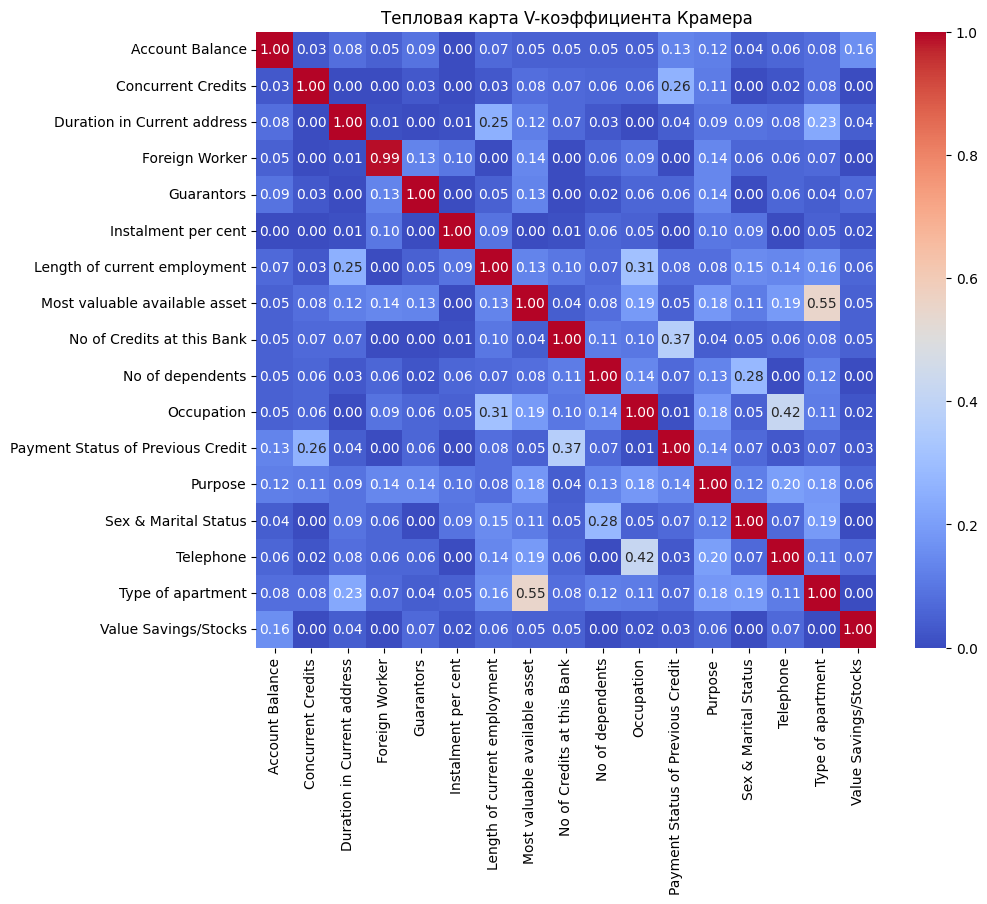

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cramers, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта V-коэффициента Крамера')
plt.show()

### 8. Выводы по результатам анализа данных

#### 8.1. Анализ целевой переменной

- набор данных несбалансирован, что может привести к снижению точности модели, неправильным метрикам, ошибкам в интерпретации результатов.

#### 8.2. Анализ коэффициента корреляции Пирсона

- корреляции между признаками не являются высокими, однако логично отражают влияние признаков на целевую переменную;
- чем меньше срок и величина кредита, тем вероятней одобрят кредит;
- чем старше заемщик, тем менее вероятно одобрят кредит.

#### 8.3. Анализ значимости признаков для решения задачи классификации

- наиболее полезными признаками являются `Duration of Credit (month)`, `Account Balance`, `Payment Status of Previous Credit`;
- наименее полезными могут быть следующие признаки ```Instalment per cent```, ```Sex & Marital Status```, ```Guarantors```,  ```Duration in Current address```, ```No of Credits at this Bank```, ```Occupation```, ```No of dependents```, ```Telephone```, ```Foreign Worker```;
- `Most valuable available asset` достаточно сильно коррелирует с `Type of apartment`;
- `Payment Status of Previous Credit` достаточно сильно коррелирует с  `No of Credits at this Bank`;
- `Occupation` достаточно сильно коррелирует с  `Telephone`.

### 9. Разбиение данных на тренировочную и тестовую выборку

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.25, random_state=42)

### 10. Обучение базовой модели градиентного бустинга на основе гистограммы

#### 10.1. Создание экземпляра и обучение модели

In [35]:
model_hist_boost = HistGradientBoostingClassifier(random_state=42)
model_hist_boost.fit(X_train[numeric_columns], y_train)

HistGradientBoostingClassifier(random_state=42)

#### 10.2. Предсказание на тренировочной и тестовой выборках

In [36]:
y_train_predict = model_hist_boost.predict(X_train[numeric_columns])
y_test_predict = model_hist_boost.predict(X_test[numeric_columns])

#### 10.3. Анализ метрик на тренировочных и тестовых данных

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)

recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)

f1_train = f1_score(y_train, y_train_predict)
f1_test = f1_score(y_test, y_test_predict)

roc_auc_train = roc_auc_score(y_train, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

print(
  f'Точность на тренировочной выборке: {accuracy_train}',
  f'Точность на тестовой выборке: {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочной выборке: {recall_train}',
  f'Полнота на тестовой выборке: {recall_test}',
  '----------------------------------------------------',
  f'F-мера на тренировочной выборке: {f1_train}',
  f'F-мера на тестовой выборке: {f1_test}',
  '----------------------------------------------------',
  f'ROC AUC на тренировочной выборке: {roc_auc_train}',
  f'ROC AUC на тестовой выборке: {roc_auc_test}',
  sep='\n'
)

Точность на тренировочной выборке: 0.9333333333333333
Точность на тестовой выборке: 0.668
Полнота на тренировочной выборке: 0.979047619047619
Полнота на тестовой выборке: 0.7942857142857143
F-мера на тренировочной выборке: 0.9536178107606679
F-мера на тестовой выборке: 0.7700831024930748
ROC AUC на тренировочной выборке: 0.9028571428571428
ROC AUC на тестовой выборке: 0.5838095238095238


#### 10.4. classification_report

In [37]:
print(classification_report(y_test, y_test_predict))

              precision    recall  f1-score   support

           0       0.44      0.37      0.40        75
           1       0.75      0.79      0.77       175

    accuracy                           0.67       250
   macro avg       0.59      0.58      0.59       250
weighted avg       0.65      0.67      0.66       250



#### 10.5. Анализ матрицы ошибок на тестовых данных

In [38]:
error_matrix = confusion_matrix(y_test, y_test_predict)
error_matrix

array([[ 28,  47],
       [ 36, 139]], dtype=int64)

In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  f'Ложно положительные (false positives, FP):  {fp}',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

Истинно отрицательные (true negatives, TN): 28
Ложно положительные (false positives, FP):  47
Ложно отрицательные (false negatives, FN):  36
Истинно положительные (true positives, TP): 139


#### 10.6. Анализ значимости признаков

Поскольку у модели `HistGradientBoostingClassifier` из библиотеки scikit-learn нет атрибута `feature_importances_`, то для оценки важности признаков воспользуемся альтернативным подходом - перестановочным (permutation) методом. Этот метод случайно переставляет значения одного признака и измеряет, как это влияет на производительность модели. Если производительность значительно ухудшается, признак считается важным.

In [ ]:
# Вычисление важности признаков с помощью перестановочного метода
result = permutation_importance(model_hist_boost, X_test[numeric_columns], y_test, n_repeats=10, random_state=42)

# Вывод важности признаков
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{numeric_columns[i]}: "
              f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")

Duration of Credit (month): 0.044 +/- 0.018
Credit Amount: 0.036 +/- 0.013


### 10.4. Выводы по результатам обучения базовой модели градиентного бустинга на основе гистограммы

Можно отметить, что `градиентный бустинг` также имеет более хорошую способность предсказывать положительные случаи, но имеет проблемы с отрицательными, часто ошибаясь при их предсказании, как и `метод опорных векторов`.

Но `градиентный бустинг` лучше справляется с предсказаниями отрицательных случаев (TN 28 против 7), но хуже с предсказаниями положительных случаев (TP 139 против 172).

метрики
По вышеперечисленным метрикам можно осделать вывод, что модель хорошо работает на тренировочных данных, но ее производительность на новых данных снижается, что может быть связано с переобучением модели.


classification_report
Эти результаты указывают на то, что модель имеет более высокую производительность для класса 1, но значительно хуже для класса 0. Это может быть связано с несбалансированностью классов в данных (что, как мы знаем из [первого домашнего задания](https://colab.research.google.com/drive/1vOCDQNlQitBE9cQQF1_xemsU8OiOavgz?usp=sharing), имеет место быть) или с тем, что модель не справляется с определением истинных наблюдений класса 0.

признаки
Получаем, что при случайной перестановке значений признака "Duration of Credit (month)" модель потеряла бы примерно 4.4% своей производительности, а при перестановке значений признака "Credit Amount" - примерно 3.6%. Значения "+/- 1.8" и "+/- 1.3" указывают на стандартное отклонение оценок важности признаков, что позволяет оценить неопределенность в этих оценках.

"Duration of Credit (month)" имеет более высокую важность, чем "Credit Amount", что может указывать на то, что продолжительность кредита имеет более значительное влияние на кредитоспособность по сравнению с суммой кредита. Возраст "Age (years)" получается вообще не влияет на кредитоспособность.

Однако, важно помнить, что важность признаков, полученная с помощью перестановочного метода, зависит от производительности модели и может быть искажена, если модель переобучена или если признаки сильно коррелируют между собой. В таких случаях, важность признаков может быть переоценена или недооценена. Кроме того, перестановочная важность признаков не отражает встроенную важность признака в модели, а лишь показывает, насколько сильно модель зависит от этого признака для предсказания.

На основе этих значений важности признаков можно понять, какие признаки наиболее важны для модели и как они влияют на ее производительность. Это может помочь в дальнейшем улучшении модели путем выбора подходящих признаков для обучения или в понимании, какие признаки могут быть наиболее полезны для улучшения качества предсказаний.

### 11. Обучение модели CatBoost

#### 11.1. Создание и обучение модели

In [ ]:
catboost_classifier = CatBoostClassifier(verbose=False, random_state=42)
catboost_classifier.fit(X_train[numeric_columns], y_train, verbose=False)

#### 11.2. Предсказание на тренировочных и тестовых данных

In [ ]:
y_train_cboost_predict = catboost_classifier.predict(X_train[numeric_columns])
y_test_cboost_predict = catboost_classifier.predict(X_test[numeric_columns])

#### 11.3. Анализ метрик на тренировочных и тестовых данных

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_cboost_predict)
accuracy_test = accuracy_score(y_test, y_test_cboost_predict)

recall_train = recall_score(y_train, y_train_cboost_predict)
recall_test = recall_score(y_test, y_test_cboost_predict)

f1_train = f1_score(y_train, y_train_cboost_predict)
f1_test = f1_score(y_test, y_test_cboost_predict)

roc_auc_train = roc_auc_score(y_train, y_train_cboost_predict)
roc_auc_test = roc_auc_score(y_test, y_test_cboost_predict)

print(
  f'Точность на тренировочной выборке: {accuracy_train}',
  f'Точность на тестовой выборке: {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочной выборке: {recall_train}',
  f'Полнота на тестовой выборке: {recall_test}',
  '----------------------------------------------------',
  f'F-мера на тренировочной выборке: {f1_train}',
  f'F-мера на тестовой выборке: {f1_test}',
  '----------------------------------------------------',
  f'ROC AUC на тренировочной выборке: {roc_auc_train}',
  f'ROC AUC на тестовой выборке: {roc_auc_test}',
  sep='\n'
)

Точность на тренировочной выборке: 0.831
Точность на валидационной выборке: 0.724

Полнота на тренировочной выборке: 0.989
Полнота на валидационной выборке: 0.937

F-мера на тренировочной выборке: 0.891
F-мера на валидационной выборке: 0.826

ROC AUC на тренировочной выборке: 0.725
ROC AUC на валидационной выборке: 0.582


#### 11.4 classification_report

In [ ]:
print(classification_report(y_test, y_test_cboost_predict))

Отчет классификации на валидационной выборке:
              precision    recall  f1-score   support

           0       0.61      0.23      0.33        75
           1       0.74      0.94      0.83       175

    accuracy                           0.72       250
   macro avg       0.67      0.58      0.58       250
weighted avg       0.70      0.72      0.68       250



#### 11.5. Анализ матрицы ошибок на тестовых данных

In [ ]:
error_matrix = confusion_matrix(y_test, y_test_predict)
error_matrix

Матрица ошибок:


array([[ 17,  58],
       [ 11, 164]])


истинно отрицательные (True Negatives, TN)	 17
ложно положительные (False Positives, FP)	 58
ложно отрицательные (False Negatives, FN)	 11
истинно положительные (True Positives, TP)	 164


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_cboost_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  f'Ложно положительные (false positives, FP):  {fp}',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

#### 11.6. Анализ значимости признаков

`PredictionValuesChange` показывает, насколько изменились предсказания модели при изменении значения признака.

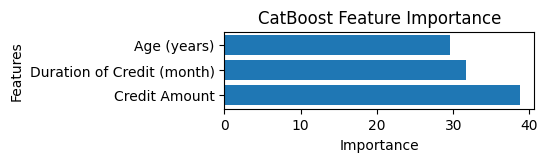

In [ ]:
# Получение важности признаков
importances = catboost_classifier.get_feature_importance(type='PredictionValuesChange')

# Создание pandas Series для удобства визуализации
feature_importances = pd.Series(importances, index=X_train[numeric_columns]).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(4, 1))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### Текущие выводы

Эти результаты указывают на то, что модель `CatBoost` аналогично `градиентному бустингу от sklearn` хорошо работает на тренировочных данных, но ее производительность на новых данных снижается. Это, опять же, может быть связано с переобучением модели.

Если сравнивать с `градиентным бустингом от sklearn`:
- точность на валидационных данных несколько выше: 0.668 против 0.724, что незначительно выше результата `метода опорных векторов` из первого домашнего задания 0.716,
- полнота также выше: 0.79 против 0.94, но меньше `метода опорных векторов` 0.98,
- F-мера тоже выше: 0.77 против 0.83, что соответствует `методу опорных векторов`,
- ROC AUC аналогный: 0.58.

Сравнивая отчеты классификации для моделей `CatBoost` и `HistGradientBoostingClassifier` на валидационной выборке, можно сделать следующие выводы:

- **Точность (Accuracy)**: Модель `CatBoost` показывает общую точность 0.72, в то время как `HistGradientBoostingClassifier` показывает 0.67. Это указывает на то, что `CatBoost` лучше справляется с обнаружением правильных классов на валидационной выборке.

- **Полнота (Recall)**: Для класса 0 полнота `CatBoost` составляет 0.23, в то время как для `HistGradientBoostingClassifier` — 0.37. Для класса 1 полнота `CatBoost` составляет 0.94, в то время как для `HistGradientBoostingClassifier` — 0.79. Это указывает на то, что `CatBoost` лучше справляется с обнаружением положительных случаев класса 1, но хуже с обнаружением положительных случаев класса 0.

- **F-мера (F1 Score)**: F-мера для класса 0 у `CatBoost` составляет 0.33, в то время как для `HistGradientBoostingClassifier` — 0.40. Для класса 1 F-мера у `CatBoost` составляет 0.83, в то время как для `HistGradientBoostingClassifier` — 0.77. Это указывает на то, что `CatBoost` лучше справляется с балансированием между точностью и полнотой для класса 1, но хуже для класса 0.

- **Средние значения (Macro Average, Weighted Average)**: Macro Average у `CatBoost` составляет 0.67, в то время как для `HistGradientBoostingClassifier` — 0.59. Weighted Average у `CatBoost` составляет 0.70, в то время как для `HistGradientBoostingClassifier` — 0.65. Это указывает на то, что `CatBoost` лучше справляется с обнаружением положительных случаев класса 1, но хуже с обнаружением положительных случаев класса 0, учитывая вес классов.

В целом, эти результаты указывают на то, что модель `CatBoost` лучше справляется с задачей классификации на валидационной выборке, особенно для класса 1. Однако, для класса 0 производительность `CatBoost хуже`, чем у `HistGradientBoostingClassifier`. Это может быть связано с различиями в алгоритмах обучения и предсказания этих моделей.

Можно отметить, что `CatBoost` также имеет более хорошую способность предсказывать положительные случаи, но имеет проблемы с отрицательными, часто ошибаясь при их предсказании, как и `метод опорных векторов`, и модель от sklearn.

Но `CatBoost` хуже справляется с предсказаниями отрицательных случаев (TN 17 против 28), но лучше с предсказаниями положительных случаев (TP 164 против 139), чем `градиентный бустинг`.

В случае `CatBoost` "Duration of Credit (month)" имеет менее высокую важность, чем "Credit Amount", в отличии от модели sklearn.

В `CatBoost` возраст "Age (years)" играет значительную роль для принятия решения.

### 12. Обучение модели градиентного бустинга на основе гистограммы с категориальными признаками

#### 12.1. Создание и обучение модели

In [ ]:
categorical_features_indices = [X_train.columns.get_loc(c) for c in categorical_columns]

catboost_classifier_all = HistGradientBoostingClassifier(categorical_features=categorical_features_indices, random_state=42)
catboost_classifier_all.fit(X_train, y_train)

#### 12.2. Предсказание на тренировочных и тестовых данных

In [ ]:
y_train_cboost_all_predict = catboost_classifier_all.predict(X_train)
y_test_cboost_all_predict = catboost_classifier_all.predict(X_test)

#### 12.3. Анализ метрик на тренировочных и тестовых данных

In [ ]:
accuracy_train = accuracy_score(y_train, y_train_cboost_all_predict)
accuracy_test = accuracy_score(y_test, y_test_cboost_all_predict)

recall_train = recall_score(y_train, y_train_cboost_all_predict)
recall_test = recall_score(y_test, y_test_cboost_all_predict)

f1_train = f1_score(y_train, y_train_cboost_all_predict)
f1_test = f1_score(y_test, y_test_cboost_all_predict)

roc_auc_train = roc_auc_score(y_train, y_train_cboost_all_predict)
roc_auc_test = roc_auc_score(y_test, y_test_cboost_all_predict)

print(
  f'Точность на тренировочной выборке: {accuracy_train}',
  f'Точность на тестовой выборке: {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочной выборке: {recall_train}',
  f'Полнота на тестовой выборке: {recall_test}',
  '----------------------------------------------------',
  f'F-мера на тренировочной выборке: {f1_train}',
  f'F-мера на тестовой выборке: {f1_test}',
  '----------------------------------------------------',
  f'ROC AUC на тренировочной выборке: {roc_auc_train}',
  f'ROC AUC на тестовой выборке: {roc_auc_test}',
  sep='\n'
)

Точность на тренировочной выборке: 1.000
Точность на валидационной выборке: 0.772

Полнота на тренировочной выборке: 1.000
Полнота на валидационной выборке: 0.869

F-мера на тренировочной выборке: 1.000
F-мера на валидационной выборке: 0.842

ROC AUC на тренировочной выборке: 1.000
ROC AUC на валидационной выборке: 0.708

----------------------------------------
Матрица ошибок:


array([[ 41,  34],
       [ 23, 152]])


истинно отрицательные (True Negatives, TN)	 41
ложно положительные (False Positives, FP)	 34
ложно отрицательные (False Negatives, FN)	 23
истинно положительные (True Positives, TP)	 152

----------------------------------------
Важность признаков:
Account Balance: 0.068 +/- 0.017
Duration of Credit (month): 0.042 +/- 0.013
Credit Amount: 0.038 +/- 0.014
No of Credits at this Bank: 0.012 +/- 0.003


#### 12.4. Анализ матрицы ошибок на тестовых данных

In [ ]:
error_matrix = confusion_matrix(y_test, y_test_cboost_all_predict)
error_matrix

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_cboost_all_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  f'Ложно положительные (false positives, FP):  {fp}',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

#### 12.5. Анализ значимости признаков

In [ ]:
# Вычисление важности признаков с помощью перестановочного метода
result = permutation_importance(catboost_classifier_all, X_test, y_test, n_repeats=10, random_state=42)
print('-' * 40)
# Вывод важности признаков
print('Важность признаков:')
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{list(X_test.columns)[i]}: "
              f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")

Отметим, что после добавления категориальных признаков на тренировочных данных модель отрабатывает по максимуму, что говорит скорее всего о переобучении.

На валидационных данных:
- точность возросла с 0.67 до 0.77,
- полнота возросла с 0.79 до 0.87,
- F-мера возрасла с 0.77 до 0.84,
- ROC AUC существнно вырос с 0.58 до 0.71.

Матрица ошибок также показывает улучшение модели как в опрделении положительных случаев, так и отрицательных.

К значимым признакам добавились `Account Balance`, который теперь является самым важным, и `No of Credits at this Bank`, который обладает какой-то минимальной важностью.

Таким образом, добавление категориальных признаков существенно улучшило модель.

### 13. Обучение модели градиентного бустинга на основе гистограммы с оптимизированными гиперпараметрами

In [ ]:
# Определение гиперпараметров для поиска
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [10, 20, 30],
    'max_leaf_nodes': [30, 50, 70]
}

# Создание экземпляра GridSearchCV
grid_search = GridSearchCV(catboost_classifier_all, param_grid, cv=5, scoring='accuracy')

# Обучение модели с использованием поиска по сетке
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
print("Best parameters: ", grid_search.best_params_)

# Вывод наилучшей точности
print("Best accuracy: ", grid_search.best_score_)

Best parameters:  {'learning_rate': 0.1, 'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 10}
Best accuracy:  0.764


In [ ]:
# Создание и обучение модели с оптимизированными параметрами
model_hist_opt = HistGradientBoostingClassifier(
    categorical_features=categorical_features_indices,
    learning_rate=0.1,
    max_depth=7,
    max_leaf_nodes=30,
    min_samples_leaf=10,
    random_state=42)
model_hist_opt.fit(X_train, y_train)

# Предсказание на тренировочной и валидационной выборках
y_train_pred_hist_opt = model_hist_opt.predict(X_train)
y_test_pred_hist_opt = model_hist_opt.predict(X_test)

#### 13.3. Анализ метрик на тренировочных и тестовых данных

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred_hist_opt)
test_accuracy = accuracy_score(y_test, y_test_pred_hist_opt)
print(f'Точность на тренировочной выборке: {train_accuracy:.3f}')
print(f'Точность на валидационной выборке: {test_accuracy:.3f}')
print()
train_recall = recall_score(y_train, y_train_pred_hist_opt)
test_recall = recall_score(y_test, y_test_pred_hist_opt)
print(f'Полнота на тренировочной выборке: {train_recall:.3f}')
print(f'Полнота на валидационной выборке: {test_recall:.3f}')
print()
train_f1 = f1_score(y_train, y_train_pred_hist_opt)
test_f1 = f1_score(y_test, y_test_pred_hist_opt)
print(f'F-мера на тренировочной выборке: {train_f1:.3f}')
print(f'F-мера на валидационной выборке: {test_f1:.3f}')
print()
train_roc_auc = roc_auc_score(y_train, y_train_pred_hist_opt)
test_roc_auc = roc_auc_score(y_test, y_test_pred_hist_opt)
print(f'ROC AUC на тренировочной выборке: {train_roc_auc:.3f}')
print(f'ROC AUC на валидационной выборке: {test_roc_auc:.3f}')
print()

Точность на тренировочной выборке: 0.997
Точность на валидационной выборке: 0.760

Полнота на тренировочной выборке: 1.000
Полнота на валидационной выборке: 0.851

F-мера на тренировочной выборке: 0.998
F-мера на валидационной выборке: 0.832

ROC AUC на тренировочной выборке: 0.996
ROC AUC на валидационной выборке: 0.699

----------------------------------------
Матрица ошибок:


array([[ 41,  34],
       [ 26, 149]])


истинно отрицательные (True Negatives, TN)	 41
ложно положительные (False Positives, FP)	 34
ложно отрицательные (False Negatives, FN)	 26
истинно положительные (True Positives, TP)	 149

----------------------------------------
Важность признаков:
Account Balance: 0.066 +/- 0.019
Duration of Credit (month): 0.038 +/- 0.014


#### 13.4. Анализ матрицы ошибок на тестовых данных

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_hist_opt)
print('-' * 40)
print("Матрица ошибок:")
display(cm)
print()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_hist_opt).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)
print()

#### 13.5. Анализ значимости признаков

In [ ]:
# Вычисление важности признаков с помощью перестановочного метода
result = permutation_importance(model_hist_opt, X_test, y_test, n_repeats=10, random_state=42)
print('-' * 40)
# Вывод важности признаков
print('Важность признаков:')
for i in result.importances_mean.argsort()[::-1]:
    if result.importances_mean[i] - 2 * result.importances_std[i] > 0:
        print(f"{list(X_test.columns)[i]}: "
              f"{result.importances_mean[i]:.3f}"
              f" +/- {result.importances_std[i]:.3f}")

#### 13.6. Выводы

Такая оптимизация быстрая "на глаз" не принесла положительных результатов.

### 14. Обучение модели CatBoost с категориальными признаками

In [ ]:
# Создание экземпляра CatBoostClassifier с указанием категориальных признаков
model_cb_with_cat = CatBoostClassifier(verbose=False, random_state=42,
                                       cat_features=categorical_features_indices)

# Обучение модели на тренировочных данных
model_cb_with_cat.fit(X_train, y_train, verbose=False)

# Предсказание на тренировочной и валидационной выборках
y_train_pred_cb_with_cat = model_cb_with_cat.predict(X_train)
y_test_pred_cb_with_cat = model_cb_with_cat.predict(X_test)

#### 14.3. Анализ метрик на тренировочных и тестовых данных

Точность на тренировочной выборке: 0.849
Точность на валидационной выборке: 0.760

Полнота на тренировочной выборке: 0.975
Полнота на валидационной выборке: 0.903

F-мера на тренировочной выборке: 0.901
F-мера на валидационной выборке: 0.840

ROC AUC на тренировочной выборке: 0.765
ROC AUC на валидационной выборке: 0.665

----------------------------------------
Матрица ошибок:


array([[ 32,  43],
       [ 17, 158]])


истинно отрицательные (True Negatives, TN)	 32
ложно положительные (False Positives, FP)	 43
ложно отрицательные (False Negatives, FN)	 17
истинно положительные (True Positives, TP)	 158



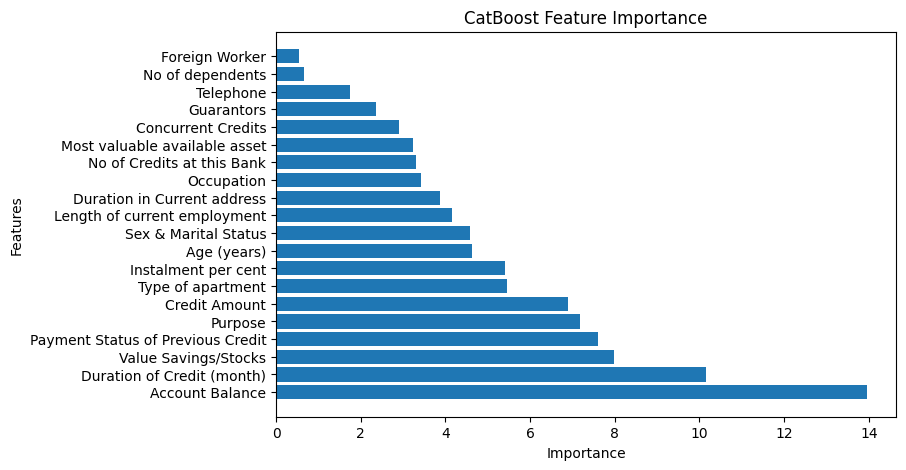

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred_cb_with_cat)
test_accuracy = accuracy_score(y_test, y_test_pred_cb_with_cat)
print(f'Точность на тренировочной выборке: {train_accuracy:.3f}')
print(f'Точность на валидационной выборке: {test_accuracy:.3f}')
print()
train_recall = recall_score(y_train, y_train_pred_cb_with_cat)
test_recall = recall_score(y_test, y_test_pred_cb_with_cat)
print(f'Полнота на тренировочной выборке: {train_recall:.3f}')
print(f'Полнота на валидационной выборке: {test_recall:.3f}')
print()
train_f1 = f1_score(y_train, y_train_pred_cb_with_cat)
test_f1 = f1_score(y_test, y_test_pred_cb_with_cat)
print(f'F-мера на тренировочной выборке: {train_f1:.3f}')
print(f'F-мера на валидационной выборке: {test_f1:.3f}')
print()
train_roc_auc = roc_auc_score(y_train, y_train_pred_cb_with_cat)
test_roc_auc = roc_auc_score(y_test, y_test_pred_cb_with_cat)
print(f'ROC AUC на тренировочной выборке: {train_roc_auc:.3f}')
print(f'ROC AUC на валидационной выборке: {test_roc_auc:.3f}')
print()

#### 14.4. Анализ матрицы ошибок на тестовых данных

In [ ]:
cm = confusion_matrix(y_test, y_test_pred_cb_with_cat)
print('-' * 40)
print("Матрица ошибок:")
display(cm)
print()

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_cb_with_cat).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)
print()

#### 14.5. Анализ значимости признаков

In [1]:
# Получение важности признаков
importances = model_cb_with_cat.get_feature_importance(type='PredictionValuesChange')

# Создание pandas Series для удобства визуализации
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(8, 5))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

NameError: name 'model_cb_with_cat' is not defined

#### 14.6. Выводы

Отметим, что после добавления категориальных признаков на тренировочных данных метрики модели изменились незначительно.

На валидационных данных:
- точность возросла с 0.72 до 0.76,
- полнота уменьшилась с 0.94 до 0.90,
- F-мера возрасла с 0.83 до 0.84,
- ROC AUC вырос с 0.58 до 0.67.

Матрица ошибок показывает улучшение модели в определении отрицательных случаев, но при этом ухудшение положительных.

Самым важным признаком оказался `Account Balance`. `Duration of Credit (month)` - второй по важности, а `Credit Amount` замыкает шестерку наиболее важных признаков.

Таким образом, добавление категориальных признаков незначительно, но улучшило модель.

### 15. Обучение модели CatBoost с оптимизированными гиперпараметрами

In [ ]:
def objective(trial):
    # использует гиперпараметры, предложенные Optuna, для обучения модели CatBoostClassifier
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostClassifier(**params, silent=True)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)
    return rmse


# study используется для оптимизации функции objective с целью минимизации RMSE
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2024-03-30 06:08:50,664] A new study created in memory with name: no-name-059b10c3-b71f-44a8-9494-2134f65d08a6
[I 2024-03-30 06:08:51,497] Trial 0 finished with value: 0.48579831205964474 and parameters: {'learning_rate': 0.04529412961260076, 'depth': 3, 'subsample': 0.49246493423712145, 'colsample_bylevel': 0.8595258084065421, 'min_data_in_leaf': 96}. Best is trial 0 with value: 0.48579831205964474.
[I 2024-03-30 06:08:52,271] Trial 1 finished with value: 0.4939635614091388 and parameters: {'learning_rate': 0.004125134529148226, 'depth': 3, 'subsample': 0.3329343262485561, 'colsample_bylevel': 0.6371393114516493, 'min_data_in_leaf': 100}. Best is trial 0 with value: 0.48579831205964474.
[I 2024-03-30 06:08:56,181] Trial 2 finished with value: 0.5019960159204453 and parameters: {'learning_rate': 0.03294801500598226, 'depth': 10, 'subsample': 0.5574716149162697, 'colsample_bylevel': 0.414621857802143, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.48579831205964474.
[I 2024-0

In [ ]:
# Получение лучших гиперпараметров
best_params = study.best_params
best_params

{'learning_rate': 0.018156381864795502,
 'depth': 5,
 'subsample': 0.7605288365539202,
 'colsample_bylevel': 0.2192698103384754,
 'min_data_in_leaf': 52}

In [ ]:
# Создание и обучение модели с лучшими гиперпараметрами
model_cb_opt = CatBoostClassifier(**best_params, verbose=False, random_state=42)
model_cb_opt.fit(X_train, y_train, verbose=False)

# Предсказание на тренировочной и валидационной выборках
y_train_pred_cb_opt = model_cb_opt.predict(X_train)
y_test_pred_cb_opt = model_cb_opt.predict(X_test)

#### 15.3. Анализ метрик на тренировочных и тестовых данных

Точность на тренировочной выборке: 0.976
Точность на валидационной выборке: 0.772

Полнота на тренировочной выборке: 0.998
Полнота на валидационной выборке: 0.869

F-мера на тренировочной выборке: 0.983
F-мера на валидационной выборке: 0.842

ROC AUC на тренировочной выборке: 0.961
ROC AUC на валидационной выборке: 0.708

----------------------------------------
Матрица ошибок:


array([[ 41,  34],
       [ 23, 152]])


истинно отрицательные (True Negatives, TN)	 41
ложно положительные (False Positives, FP)	 34
ложно отрицательные (False Negatives, FN)	 23
истинно положительные (True Positives, TP)	 152



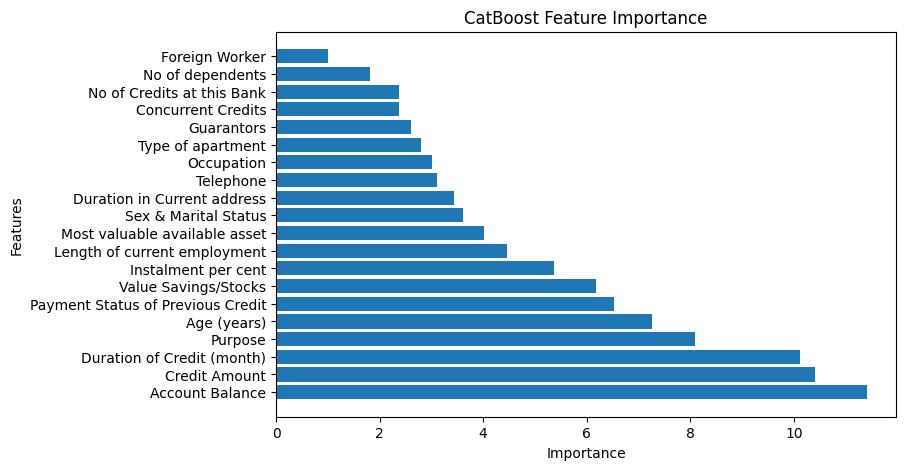

In [ ]:
train_accuracy = accuracy_score(y_train, y_train_pred_cb_opt)
test_accuracy = accuracy_score(y_test, y_test_pred_cb_opt)
print(f'Точность на тренировочной выборке: {train_accuracy:.3f}')
print(f'Точность на валидационной выборке: {test_accuracy:.3f}')
print()
train_recall = recall_score(y_train, y_train_pred_cb_opt)
test_recall = recall_score(y_test, y_test_pred_cb_opt)
print(f'Полнота на тренировочной выборке: {train_recall:.3f}')
print(f'Полнота на валидационной выборке: {test_recall:.3f}')
print()
train_f1 = f1_score(y_train, y_train_pred_cb_opt)
test_f1 = f1_score(y_test, y_test_pred_cb_opt)
print(f'F-мера на тренировочной выборке: {train_f1:.3f}')
print(f'F-мера на валидационной выборке: {test_f1:.3f}')
print()
train_roc_auc = roc_auc_score(y_train, y_train_pred_cb_opt)
test_roc_auc = roc_auc_score(y_test, y_test_pred_cb_opt)
print(f'ROC AUC на тренировочной выборке: {train_roc_auc:.3f}')
print(f'ROC AUC на валидационной выборке: {test_roc_auc:.3f}')
print()

#### 15.4. Анализ матрицы ошибок на тестовых данных

In [ ]:

cm = confusion_matrix(y_test, y_test_pred_cb_opt)
print('-' * 40)
print("Матрица ошибок:")
display(cm)
print()

tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_cb_opt).ravel()
print('истинно отрицательные (True Negatives, TN)\t', tn)
print('ложно положительные (False Positives, FP)\t', fp)
print('ложно отрицательные (False Negatives, FN)\t', fn)
print('истинно положительные (True Positives, TP)\t', tp)
print()

#### 15.5. Анализ значимсоти признаков

In [ ]:

# Получение важности признаков
importances = model_cb_opt.get_feature_importance(type='PredictionValuesChange')

# Создание pandas Series для удобства визуализации
feature_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(8, 5))
plt.barh(feature_importances.index, feature_importances.values)
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

#### 15.6. Выводы

Проведенная довольно быстрая оптимизация не привела к значительным улучшением метрик модели на валидационных данных:
- точность возросла с 0.76 до 0.77,
- полнота уменьшилась с 0.90 до 0.87,
- F-мера осталась 0.84,
- ROC AUC вырос с 0.67 до 0.71.

Матрица ошибок показывает еще большее улучшение модели в определении отрицательных случаев, и еще большее ухудшение положительных.

Претерпела изменение тройка самых важных признаков:
1. `Account Balance`,
2. `Credit Amount`,
3. `Duration of Credit (month)`.

Обратим внимание, что возраст стал играть немаловожную роль в принятии решения моделью.

### 16. Выводы

Таким образом добавление в модель sklearn категориальных признаков значительно улучшило ее.

В случае же с CatBoost улучшение незначительно.

Проведенная наспех оптимизация не привела к значимым улучшениям, можно даже говорить об ухудшении результатов в обоих случаях.

Можно предположить, что требуется более глубокая затратная по времени оптимизация параметров.

Также можно заявить, что работа обеих моделей с параметрами по умолчанию дает хорошие результаты.

# Сравнение выбранных ансамблевых моделей

## между собой

Производительность: `CatBoostClassifier` показывает более высокую точность и полноту на тренировочных данных по сравнению с `HistGradientBoostingClassifier`. Однако, на валидационных данных производительность `CatBoostClassifier` снижается, что может указывать на переобучение.

Важность признаков: Для `HistGradientBoostingClassifier` наиболее важными признаками являются "Duration of Credit (month)" и "Credit Amount", в то время как для `CatBoostClassifier` - "Account Balance" и "Credit Amount". Это указывает на различия в подходах моделей к выбору наиболее важных признаков.

Распределение ошибок: Обе модели показывают схожую тенденцию к ошибкам в предсказании отрицательных случаев, но `CatBoostClassifier` лучше справляется с положительными случаями.

## с метод опорных векторов SVC из первого домашнего задания

Производительность: `CatBoostClassifier` показывает более высокую точность и полноту на тренировочных данных по сравнению с `HistGradientBoostingClassifier` и `SVC`. Однако, на валидационных данных производительность `CatBoostClassifier` снижается, что может указывать на переобучение. `HistGradientBoostingClassifier` показывает более стабильную производительность, но с меньшей точностью и полнотой на валидационных данных. `SVC` показывает наиболее низкую производительность по сравнению с двумя ансамблевыми моделями.

Важность признаков: Для `HistGradientBoostingClassifier` наиболее важными признаками являются "Duration of Credit (month)" и "Credit Amount", в то время как для `CatBoostClassifier` - "Account Balance" и "Credit Amount". `SVC` не предоставляет информацию о важности признаков напрямую, но его производительность потенциально может быть улучшена с помощью выбора наиболее важных признаков.

Распределение ошибок: `SVC` показывает наиболее высокую полноту, но низкую точность и F-меру, что указывает на проблемы с балансом между классами. `HistGradientBoostingClassifier` и `CatBoostClassifier` показывают более сбалансированное распределение ошибок, но с различными показателями производительности.

Предложенные в условии задания модели scikit-learn:
- `случайный лес`,
- `градиентный бустинг`,
- `градиентный бустинг основанный на гистограммах`.

Для задачи классификации на наборе данных "German Credit Data" лучше выбрать `модель градиентного бустинга на основе гистограмм`, так как она обеспечивает высокую скорость обучения и предсказания.

Эта модель использует гистограммы для ускорения процесса обучения, что делает её значительно быстрее по сравнению с традиционным градиентным бустингом.

В отличие от `случайного леса`, который также является эффективным ансамблевым методом, `модель градиентного бустинга на основе гистограмм` может обеспечить более высокую точность и эффективность. Но, стоит отметить, `случайный лес` может быть более простым в интерпретации и настройке по сравнению с градиентным бустингом.

Предложенные в условии задания "внешние" модели:
- градиентный бустинг `CatBoost`,
- градиентный бустинг `XGBoost`,
- градиентный бустинг `LightGBM`.

Для выбора модели из указанных для классификации набора данных "German Credit Data", следует учесть следующее:

- **Обработка категориальных признаков**: `CatBoost` имеет встроенную поддержку категориальных признаков. Это особенно полезно для набора данных "German Credit Data", в котором 17 категориальных признаков.

- **Скорость обучения и предсказания**: `LightGBM` известен своей высокой скоростью обучения и предсказания. Это полезно, когда время обучения ограниченно.

- **Производительность и гибкость**: `CatBoost` и `XGBoost` предлагают высокую производительность и гибкость в настройке гиперпараметров. Но `CatBoost` может предложить лучшие результаты по умолчанию, это полезно для быстрого получения хороших результатов без глубокой настройки.

Исходя из вышесказанного, `CatBoost` наиболее предпочтителен для классификации набора данных "German Credit Data". Он предлагает встроенную поддержку категориальных признаков и может обеспечить хорошие результаты по умолчанию для быстрого получения хороших результатов без глубокой настройки.